# Studies on VBF jet selection

Authors: Zichun Hao and Raghav Kansal

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker
import numpy as np

import uproot
import awkward as ak
from coffea import nanoevents

from coffea.nanoevents.methods.base import NanoEventsArray
from coffea.analysis_tools import Weights, PackedSelection
from coffea.nanoevents.methods import nanoaod
from coffea.nanoevents.methods import vector
from coffea.lookup_tools.dense_lookup import dense_lookup
from tqdm import tqdm

from HHbbVV.processors.utils import pad_val

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 24})

import warnings

warnings.filterwarnings("ignore")

In [2]:
from datetime import datetime
from pathlib import Path

MAIN_DIR = Path("../../../")
DATA_DIR = MAIN_DIR.resolve().parent / "data"
# samples_dir = "/ceph/cms/store/user/annava/projects/HHbbVV/24Mar5AllYears"

# date = "24Mar6"
date = datetime.now().strftime("%Y%m%d")
plot_dir = MAIN_DIR / f"plots/Kinematics/{date}"
plot_dir.mkdir(parents=True, exist_ok=True)

Look at single SM VBF HH signal NanoAOD file

In [3]:
events = nanoevents.NanoEventsFactory.from_root(
    # "root://cmseos.fnal.gov///store/user/lpcpfnano/cmantill/v2_3/2018/HH/VBF_HHTobbVV_CV_1_C2V_0_C3_1_TuneCP5_13TeV-madgraph-pythia8/VBF_HHTobbVV_CV_1_C2V_0_C3_1/220808_150000/0000/nano_mc2018_1-1.root",
    str(DATA_DIR / "vbf.root"),
    # f,
    schemaclass=nanoevents.NanoAODSchema,
).events()

Z_PDGID = 23
W_PDGID = 24
HIGGS_PDGID = 25
b_PDGID = 5
GEN_FLAGS = ["fromHardProcess", "isLastCopy"]

## Generator Level Studies

Get generator-level Higgs and Vs

In [4]:
higgs = events.GenPart[
    (abs(events.GenPart.pdgId) == HIGGS_PDGID) * events.GenPart.hasFlags(GEN_FLAGS)
]

higgs_children = higgs.children

# finding bb and VV children
is_bb = abs(higgs_children.pdgId) == b_PDGID
is_VV = (abs(higgs_children.pdgId) == W_PDGID) + (abs(higgs_children.pdgId) == Z_PDGID)

Hbb = higgs[ak.any(is_bb, axis=2)]
HVV = higgs[ak.any(is_VV, axis=2)]

# make sure we're only getting one Higgs
Hbb = ak.pad_none(Hbb, 1, axis=1)[:, 0]
HVV = ak.pad_none(HVV, 1, axis=1)[:, 0]

vs = events.GenPart[((abs(events.GenPart.pdgId) == 24)) * events.GenPart.hasFlags(GEN_FLAGS)]

# vbf output quarks are always at index 4, 5
gen_quarks = events.GenPart[events.GenPart.hasFlags(["isHardProcess"])][:, 4:6]

Check gen-level plots

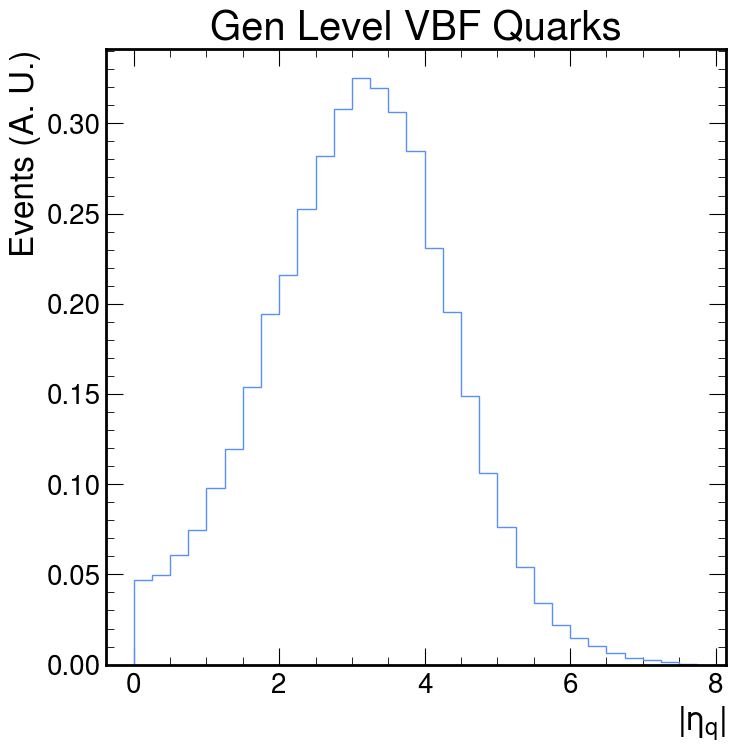

In [5]:
plt.figure(figsize=(8, 8))
plt.title("Gen Level VBF Quarks")
plt.hist(ak.flatten(np.abs(gen_quarks.eta)), np.arange(0, 8, 0.25), histtype="step", density=True)
plt.xlabel(r"$|\eta_{q}|$")
plt.ylabel("Events (A. U.)")
plt.savefig(plot_dir / "gen_vbf_quarks_eta.pdf", bbox_inches="tight")
plt.show()

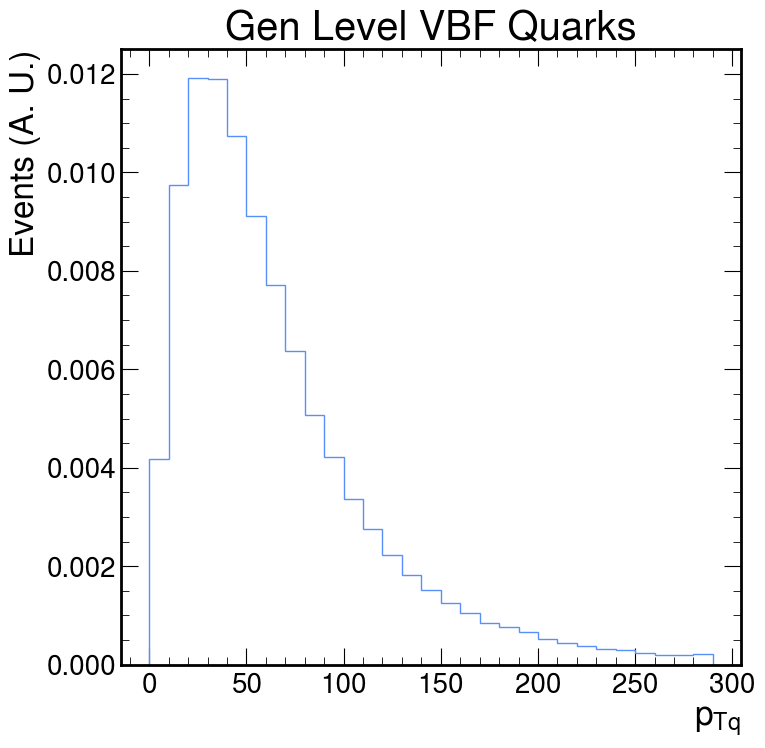

In [6]:
plt.figure(figsize=(8, 8))
plt.title("Gen Level VBF Quarks")
plt.hist(ak.flatten(gen_quarks.pt), np.arange(0, 300, 10), histtype="step", density=True)
plt.xlabel(r"$p_{Tq}$")
plt.ylabel("Events (A. U.)")
plt.savefig(plot_dir / "gen_vbf_quarks_pt.pdf", bbox_inches="tight")
plt.show()

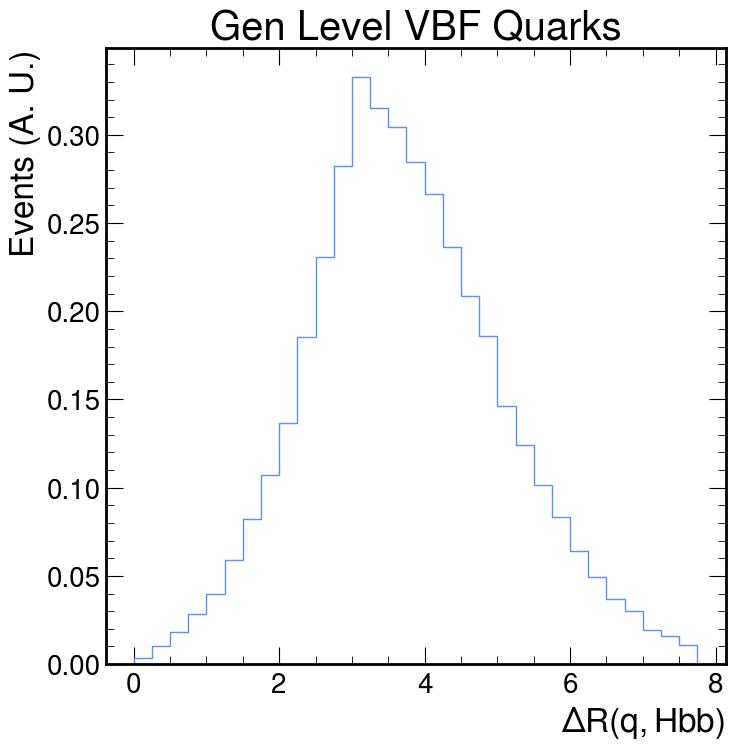

In [7]:
plt.figure(figsize=(8, 8))
plt.title("Gen Level VBF Quarks")
plt.hist(ak.flatten(Hbb.delta_r(gen_quarks)), np.arange(0, 8, 0.25), histtype="step", density=True)
plt.xlabel(r"$\Delta R(q, Hbb)$")
plt.ylabel("Events (A. U.)")
plt.savefig(plot_dir / "gen_vbf_quarks_Hbb_dr.pdf", bbox_inches="tight")
plt.show()

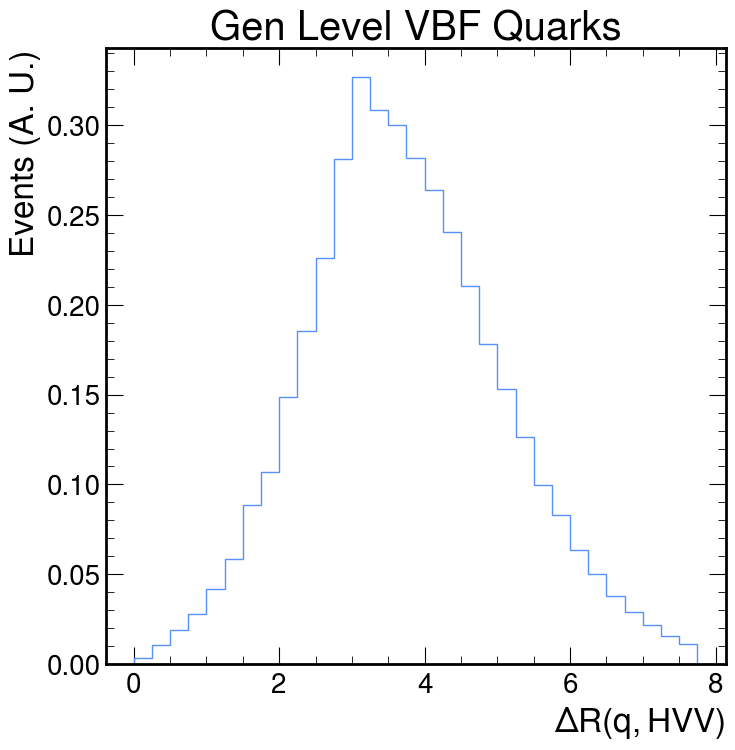

In [8]:
plt.figure(figsize=(8, 8))
plt.title("Gen Level VBF Quarks")
plt.hist(ak.flatten(HVV.delta_r(gen_quarks)), np.arange(0, 8, 0.25), histtype="step", density=True)
plt.xlabel(r"$\Delta R(q, HVV)$")
plt.ylabel("Events (A. U.)")
plt.savefig(plot_dir / "gen_vbf_quarks_HVV_dr.pdf", bbox_inches="tight")
plt.show()

Matching efficiency calculation

In [9]:
def matching_efficiency(gen_quarks, vbf_jets, matching_dr=0.4, verbose: bool = False) -> float:
    drs = ak.pad_none(vbf_jets, 2, axis=1)[:, :2].metric_table(gen_quarks)
    matched = drs < matching_dr
    # TODO: add overlap removal?

    matching_fraction = np.mean(np.all(np.any(matched, axis=2), axis=1))

    if verbose:
        print(f"Matching efficiency: {matching_fraction}")

    return matching_fraction

In [10]:
jets = events.Jet

# Only consider events with two true VBF jets
drs = jets.metric_table(gen_quarks)
matched = ak.any(drs < 0.4, axis=2)
# select events with two true VBF jets
two_vbf = ak.sum(matched, axis=1) == 2

true_vbf_jets = jets[matched]

## Baseline Selections

In [11]:
# ak8 jet preselection
preselection = {  # noqa: RUF012
    "pt": 300.0,
    "eta": 2.4,
    "VVmsd": 50,
    # "VVparticleNet_mass": [50, 250],
    # "bbparticleNet_mass": [92.5, 162.5],
    "bbparticleNet_mass": 50,
    "VVparticleNet_mass": 50,
    "bbFatJetParticleNetMD_Txbb": 0.8,
    "jetId": 2,  # tight ID bit
    "DijetMass": 800,  # TODO
    # "nGoodElectrons": 0,
}

num_jets = 2

In [12]:
fatjets = events.FatJet

fatjets = ak.pad_none(
    fatjets[(fatjets.pt > 300) * (fatjets.isTight) * (np.abs(fatjets.eta) <= 2.4)], 2, axis=1
)

# particlenet xbb vs qcd

txbb = pad_val(
    fatjets.particleNetMD_Xbb / (fatjets.particleNetMD_QCD + fatjets.particleNetMD_Xbb),
    num_jets,
    axis=1,
)

# bb VV assignment

bb_mask = txbb[:, 0] >= txbb[:, 1]
bb_mask = np.stack((bb_mask, ~bb_mask)).T

In [13]:
bbjet = fatjets[bb_mask]
vvjet = fatjets[~bb_mask]

In [14]:
sel = ak.fill_none(
    (
        (txbb[bb_mask] > 0.97)
        * (fatjets.particleNet_H4qvsQCD[~bb_mask] > 0.6)
        * (fatjets.pt[:, 0] > 500)
        * (fatjets.pt[:, 1] > 400)
        * (np.abs(fatjets[:, 0].delta_phi(fatjets[:, 1])) > 2.6)
        * (np.abs(fatjets[:, 0].eta - fatjets[:, 1].eta) < 2.0)
    ),
    False,
)

tsel = sel * two_vbf

Checking how many events have jets which match with the gen quarks

In [15]:
np.mean(ak.all(ak.any(gen_quarks.metric_table(jets) < 0.4, axis=2), axis=1)[sel])

0.5086705202312138

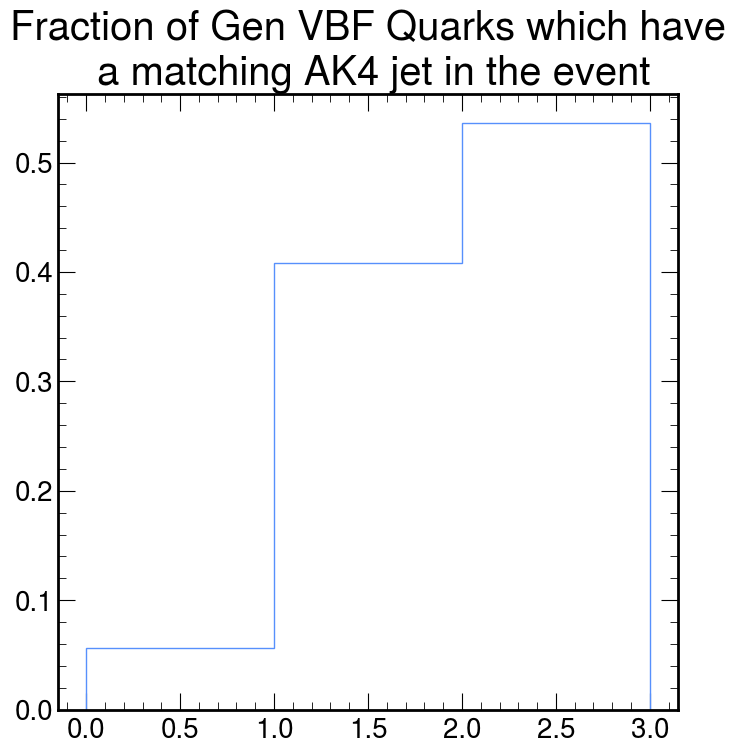

In [16]:
plt.figure(figsize=(8, 8))
plt.hist(
    ak.sum(ak.any(gen_quarks.metric_table(jets) < 0.4, axis=2), axis=1),
    [0, 1, 2, 3],
    histtype="step",
    density=True,
)
plt.title("Fraction of Gen VBF Quarks which have\n a matching AK4 jet in the event")
plt.savefig(plot_dir / "gen_matching_fraction.pdf", bbox_inches="tight")
plt.show()

Leptons

In [17]:
electrons = events.Electron
electrons = electrons[(electrons.pt > 5) & (electrons.cutBased >= electrons.LOOSE)]

muons = events.Muon
muons = muons[(muons.pt > 7) & (muons.looseId)]

## AK4 jet selections

In [18]:
from typing import Dict, Tuple, Union


def events_ak4_selected(
    ak4_jet_selection: Dict[str, Union[float, str]],
    jets: ak.Array,
    fatjets: ak.Array,
    bb_mask: ak.Array,
    electrons: ak.Array,
    muons: ak.Array,
    num_jets: int = 2,
) -> Tuple[ak.Array, ak.Array]:
    """
    Make selections on AK4 jets based on AK8 jets and leptons
    Required keys in `ak4_jet_selection`:
        - pt_min: float
        - pt_max: float
        - eta_min: float
        - eta_max: float
        - jetId: str
        - puId: str
        - dR_fatjetbb: float
        - dR_fatjetVV: float
    """
    vbf_jet_mask = (
        # jets.isTight
        (jets.pt >= ak4_jet_selection["pt_min"])
        & (jets.pt <= ak4_jet_selection["pt_max"])
        & (np.abs(jets.eta) <= ak4_jet_selection["eta_max"])
        & (np.abs(jets.eta) >= ak4_jet_selection["eta_min"])
        # & ((jets.pt > 50) | ((jets.puId & 2) == 2))
        & (
            ak.pad_none(fatjets, num_jets, axis=1, clip=True)[bb_mask].delta_r(jets)
            > ak4_jet_selection["dR_fatjetbb"]
        )
        & (
            ak.pad_none(fatjets, num_jets, axis=1, clip=True)[~bb_mask].delta_r(jets)
            > ak4_jet_selection["dR_fatjetVV"]
        )
        & ak.all(jets.metric_table(electrons) > 0.4, axis=2)
        & ak.all(jets.metric_table(muons) > 0.4, axis=2)
    )
    jets_selected = jets[vbf_jet_mask]

    return jets_selected, vbf_jet_mask

In [19]:
# ak4_jet_selection = {
#     "pt": 25,
#     "eta_min": 0,
#     "eta_max": 4.7,
#     "jetId": "tight",
#     "puId": "medium",
#     "dR_fatjetbb": 1.2,
#     "dR_fatjetVV": 0.8,
# }


ak4_jet_selection = {  # noqa: RUF012
    "pt": 15,
    "eta_min": 1,
    "eta_max": 5.1,
    # "jetId": "tight",
    # "puId": "medium",
    "dR_fatjetbb": 1.1,
    "dR_fatjetVV": 1.0,
}

# dR_fatjetVV = 0.8 used from last two cells of VBFgenInfoTests.ipynb with data generated from SM signal vbf
# https://github.com/rkansal47/HHbbVV/blob/vbf_systematics/src/HHbbVV/VBF_binder/VBFgenInfoTests.ipynb
# (0-14R1R2study.parquet) has columns of different nGoodVBFJets corresponding to R1 and R2 cuts
vbf_jet_mask = (
    # jets.isTight
    (jets.pt >= ak4_jet_selection["pt"])
    & (np.abs(jets.eta) < ak4_jet_selection["eta_max"])
    & (np.abs(jets.eta) >= ak4_jet_selection["eta_min"])
    # medium puId https://twiki.cern.ch/twiki/bin/viewauth/CMS/PileupJetIDUL
    # & ((jets.pt > 50) | ((jets.puId & 2) == 2))
    & (bbjet.delta_r(jets) > ak4_jet_selection["dR_fatjetbb"])
    & (vvjet.delta_r(jets) > ak4_jet_selection["dR_fatjetVV"])
    & ak.all(jets.metric_table(electrons) > 0.4, axis=2)
    & ak.all(jets.metric_table(muons) > 0.4, axis=2)
)[tsel]

vbf_jets = jets[tsel][vbf_jet_mask]
matching_efficiency(gen_quarks[tsel], vbf_jets)

0.7557915057915058

## Optimizing Selections

### Fatjet dR

In [20]:
vbf_jet_mask = (
    ak.all(jets.metric_table(electrons) > 0.4, axis=2)
    & ak.all(jets.metric_table(muons) > 0.4, axis=2)
)[tsel]

max_matching = [0.8, 0.8, 0]
tbbjet = bbjet[tsel]
tvvjet = vvjet[tsel]
tjets = jets[tsel]

for bbdr in tqdm(np.arange(0.6, 1.4, 0.01)):
    for vvdr in np.arange(0.6, 1.4, 0.01):
        vbf_jet_mask_dr = (
            vbf_jet_mask & (tbbjet.delta_r(tjets) > bbdr) & (tvvjet.delta_r(tjets) > vvdr)
        )
        vbf_jets = tjets[vbf_jet_mask_dr]
        me = matching_efficiency(gen_quarks[tsel], vbf_jets, verbose=False)
        if me > max_matching[-1]:
            max_matching = [bbdr, vvdr, me]

bbdr, vvdr, me = max_matching
print(f"{bbdr=}, {vvdr=}, {me=}")

100%|██████████| 80/80 [06:00<00:00,  4.51s/it]

bbdr=1.1100000000000003, vvdr=0.7500000000000001, me=0.7625482625482626


### Minimum eta

In [21]:
max_matching = [0.8, 0.8, 0]
tbbjet = bbjet[tsel]
tvvjet = vvjet[tsel]
tjets = jets[tsel]

vbf_jet_mask = (
    ak.all(jets.metric_table(electrons) > 0.4, axis=2)
    & ak.all(jets.metric_table(muons) > 0.4, axis=2)
    & (bbjet.delta_r(jets) > 1.1)
    & (vvjet.delta_r(jets) > 1.0)
)[tsel]


max_matching = [0, 0]
for etamin in np.arange(0, 2, 0.05):
    vbf_jet_mask_dr = vbf_jet_mask & (np.abs(tjets.eta) > etamin)
    vbf_jets = tjets[vbf_jet_mask_dr]
    me = matching_efficiency(gen_quarks[tsel], vbf_jets)
    if me > max_matching[-1]:
        max_matching = [etamin, me]

print(f"{etamin=}, {me=}")

etamin=1.9500000000000002, me=0.6554054054054054


### Final selection

In [22]:
telectrons = electrons[tsel]
tmuons = muons[tsel]
tbbjet = bbjet[tsel]
tvvjet = vvjet[tsel]
tjets = jets[tsel]

ak4_jet_selection = {  # noqa: RUF012
    "pt": 15,
    "eta_min": 1.95,
    "eta_max": 5.1,
    # "jetId": "tight",
    # "puId": "medium",
    "dR_fatjetbb": 1.39,
    "dR_fatjetVV": 1.39,
}

# vbf_jet_mask = (
#     # jets.isTight
#     (tjets.pt >= ak4_jet_selection["pt"])
#     & (np.abs(tjets.eta) < ak4_jet_selection["eta_max"])
#     & (np.abs(tjets.eta) >= ak4_jet_selection["eta_min"])
#     # medium puId https://twiki.cern.ch/twiki/bin/viewauth/CMS/PileupJetIDUL
#     # & ((jets.pt > 50) | ((jets.puId & 2) == 2))
#     & (tbbjet.delta_r(tjets) > ak4_jet_selection["dR_fatjetbb"])
#     & (tvvjet.delta_r(tjets) > ak4_jet_selection["dR_fatjetVV"])
#     & ak.all(tjets.metric_table(telectrons) > 0.4, axis=2)
#     & ak.all(tjets.metric_table(tmuons) > 0.4, axis=2)
# )

vbf_jet_mask = (
    # jets.isTight
    (jets.pt >= ak4_jet_selection["pt"])
    & (np.abs(jets.eta) < ak4_jet_selection["eta_max"])
    & (np.abs(jets.eta) >= ak4_jet_selection["eta_min"])
    # medium puId https://twiki.cern.ch/twiki/bin/viewauth/CMS/PileupJetIDUL
    # & ((jets.pt > 50) | ((jets.puId & 2) == 2))
    & (bbjet.delta_r(jets) > ak4_jet_selection["dR_fatjetbb"])
    & (vvjet.delta_r(jets) > ak4_jet_selection["dR_fatjetVV"])
    & ak.all(jets.metric_table(electrons) > 0.4, axis=2)
    & ak.all(jets.metric_table(muons) > 0.4, axis=2)
)[tsel]

vbf_jets = tjets[vbf_jet_mask]
matching_efficiency(gen_quarks[tsel], vbf_jets)

0.6486486486486487

In [23]:
# selected VBF jets
tmatched = matched[tsel]
# vbf_jets_selected = jets[vbf_jet_mask][:, :2][matched[vbf_jet_mask][:, :2]][tsel]
vbf_jets_selected = tjets[vbf_jet_mask][:, :2][tmatched[vbf_jet_mask][:, :2]]
# VBF jets that were not selected by AK4 selection
# vbf_jets_unselected_ak4 = jets[~vbf_jet_mask][matched[~vbf_jet_mask]][tsel]
vbf_jets_unselected_ak4 = tjets[~vbf_jet_mask][tmatched[~vbf_jet_mask]]
# VBF jets that were selected by AK4 selection but unselected by pT selection
# vbf_jets_unselected_pt = jets[vbf_jet_mask][:, 2:][matched[vbf_jet_mask][:, 2:]][tsel]
vbf_jets_unselected_pt = tjets[vbf_jet_mask][:, 2:][tmatched[vbf_jet_mask][:, 2:]]
# Fake VBF jets that were selected
# fake_jets_selected = jets[vbf_jet_mask][:, :2][~matched[vbf_jet_mask][:, :2]][tsel]
fake_jets_selected = tjets[vbf_jet_mask][:, :2][~tmatched[vbf_jet_mask][:, :2]]

tot = np.sum(tsel)
twosel = ak.count(vbf_jets_selected.pt, axis=1) == 2
onesel = ak.count(vbf_jets_selected.pt, axis=1) == 1
unsak4 = ak.count(vbf_jets_unselected_ak4.pt, axis=1) == 1
unspt = ak.count(vbf_jets_unselected_pt.pt, axis=1) == 1
zsel = ak.count(vbf_jets_selected.pt, axis=1) == 0

print(
    "Events with two true VBF jets selected:", np.sum(twosel), f"({np.sum(twosel)/ tot * 100:.1f}%)"
)
print(
    "Events with 1 VBF jet unselected because ak4 selections:",
    np.sum(unsak4),
    f"({np.sum(unsak4)/ tot * 100:.1f}%)",
)
print(
    "Events with 1 VBF jet unselected because pt:",
    np.sum(unspt),
    f"({np.sum(unspt)/ tot * 100:.1f}%)",
)
print("Events with 0 true VBF jets selected:", np.sum(zsel), f"({np.sum(zsel)/ tot * 100:.1f}%)")

Events with two true VBF jets selected: 672 (64.9%)
Events with 1 VBF jet unselected because ak4 selections: 206 (19.9%)
Events with 1 VBF jet unselected because pt: 143 (13.8%)
Events with 0 true VBF jets selected: 35 (3.4%)


Choosing highest eta_jj pair of jets

In [24]:
def highest_etajj_pair(jets, num_jets=3):
    # Pad the jets array with None values to ensure a fixed size
    jets = ak.pad_none(jets, num_jets, clip=True)
    etas = jets.eta
    # Pairwise eta differences
    # etas = ak.pad_none(jets.eta, num_jets, clip=True)
    ed = ak.fill_none(np.abs(etas[:, :, None] - etas[:, None]), 0)
    # choose the pair that has the largest eta_jj
    am = np.argmax(ak.flatten(ed, axis=2), axis=1)
    # Get the corresponding jets for the highest eta difference pair
    i1 = am // num_jets
    i2 = am % num_jets
    j1 = jets[np.arange(len(jets)), i1.to_numpy()]
    j2 = jets[np.arange(len(jets)), i2.to_numpy()]

    # Get the matched values for the highest eta difference pair
    matched1 = ak.pad_none(matched[tsel][vbf_jet_mask], num_jets, clip=True)[
        np.arange(ak.sum(tsel)), i1.to_numpy()
    ]
    matched2 = ak.pad_none(matched[tsel][vbf_jet_mask], num_jets, clip=True)[
        np.arange(ak.sum(tsel)), i2.to_numpy()
    ]

    selected_indices = ak.concatenate([ak.unflatten(i1, 1), ak.unflatten(i2, 1)], axis=1)
    selected_jets = ak.concatenate([ak.unflatten(j1, 1), ak.unflatten(j2, 1)], axis=1)
    selected_matched = ak.concatenate(
        [ak.unflatten(matched1, 1), ak.unflatten(matched2, 1)], axis=1
    )

    # return ak.concatenate([ak.unflatten(j1, 1), ak.unflatten(j2, 1)], axis=1), ak.concatenate(
    #     [ak.unflatten(matched1, 1), ak.unflatten(matched2, 1)], axis=1
    # )
    return selected_indices, selected_jets, selected_matched

In [25]:
selected_indices, selected_jets, selected_matched = highest_etajj_pair(vbf_jets)
matching_efficiency(gen_quarks[tsel], selected_jets)

0.5733590733590733

Choosing highest pT pair of jets with a minimum eta_jj value

In [26]:
def top_pt_eta_min(jets, eta_jj_min=2.0, num_jets=3):
    """Find highest pt pair of jets with |eta_jj| > 2"""
    jets = ak.pad_none(jets, num_jets, clip=True)
    eta = jets.eta

    etas = []
    i_s = []
    for i in range(num_jets):
        for j in range(i + 1, num_jets):
            etajj = ak.fill_none(np.abs(eta[:, i] - eta[:, j]) >= eta_jj_min, False)
            etas.append(etajj)
            i_s.append([i, j])

    inds = np.zeros((len(jets), 2))
    inds[:, 1] += 1

    eta_jj_cache = ~etas[0]
    for n in range(1, len(etas)):
        inds[eta_jj_cache * etas[n]] = i_s[n]
        eta_jj_cache = eta_jj_cache * ~etas[n]

    i1 = inds[:, 0].astype(int)
    i2 = inds[:, 1].astype(int)

    j1 = jets[np.arange(len(jets)), i1]
    j2 = jets[np.arange(len(jets)), i2]

    matched1 = ak.pad_none(matched[tsel][vbf_jet_mask], num_jets, clip=True)[
        np.arange(ak.sum(tsel)), i1
    ]
    matched2 = ak.pad_none(matched[tsel][vbf_jet_mask], num_jets, clip=True)[
        np.arange(ak.sum(tsel)), i2
    ]

    selected_indices = ak.concatenate([ak.unflatten(i1, 1), ak.unflatten(i2, 1)], axis=1)
    selected_jets = ak.concatenate([ak.unflatten(j1, 1), ak.unflatten(j2, 1)], axis=1)
    selected_matched = ak.concatenate(
        [ak.unflatten(matched1, 1), ak.unflatten(matched2, 1)], axis=1
    )

    return selected_indices, selected_jets, selected_matched

In [27]:
selected_indices, selected_jets, selected_matched = top_pt_eta_min(
    vbf_jets, eta_jj_min=2.8, num_jets=3
)
matching_efficiency(gen_quarks[tsel], selected_jets)

0.6843629343629344

In [28]:
max_matching = [0, 0]
best_selected_indices = None
best_selected_jets = None
best_selected_matched = None
for etamin in tqdm(np.arange(2, 5, 0.05)):
    selected_indices, selected_jets, selected_matched = top_pt_eta_min(
        vbf_jets, eta_jj_min=etamin, num_jets=4
    )
    me = matching_efficiency(gen_quarks[tsel], selected_jets)
    if me > max_matching[-1]:
        max_matching = [etamin, me]
        best_selected_indices = selected_indices
        best_selected_jets = selected_jets
        best_selected_matched = selected_matched

etamin, me = max_matching
selected_indices = best_selected_indices
selected_jets = best_selected_jets
selected_matched = best_selected_matched
print(f"{etamin=}, {me=}")

100%|██████████| 60/60 [00:08<00:00,  7.32it/s]

etamin=2.4499999999999984, me=0.6911196911196911


In [29]:
selected_indices, selected_jets, selected_matched = top_pt_eta_min(
    vbf_jets, eta_jj_min=2.45, num_jets=4
)
matching_efficiency(gen_quarks[tsel], selected_jets)

0.6911196911196911

In [30]:
twosel = ak.sum(selected_matched, axis=1) == 2
onesel = ak.sum(selected_matched, axis=1) == 1
zsel = ak.sum(selected_matched, axis=1) == 0

print(
    "Events with two true VBF jets selected:", np.sum(twosel), f"({np.sum(twosel)/ tot * 100:.1f}%)"
)
print("Events with 1 true VBF selected:", np.sum(onesel), f"({np.sum(onesel)/ tot * 100:.1f}%)")
print("Events with 0 true VBF jets selected:", np.sum(zsel), f"({np.sum(zsel)/ tot * 100:.1f}%)")

Events with two true VBF jets selected: 716 (69.1%)
Events with 1 true VBF selected: 286 (27.6%)
Events with 0 true VBF jets selected: 34 (3.3%)


In [31]:
# fake_jets_selected = vbf_jets[onesel][~selected_matched[onesel]]
# true_jets_selected = vbf_jets[onesel][selected_matched[onesel]]

true_selected_list = []
fake_selected_list = []
true_unselected_list = []

for i in range(len(vbf_jets[onesel])):
    event = vbf_jets[onesel][i]
    event_matched = tmatched[vbf_jet_mask][onesel][i]
    event_selected = selected_indices[onesel][i]

    event_true_selected_list = []
    event_fake_selected_list = []
    event_true_unselected_list = []

    for j in range(len(event)):
        jet = event[j]
        is_matched = event_matched[j]
        is_selected = j in event_selected

        if is_matched and is_selected:
            event_true_selected_list.append(jet)
        elif not is_matched and is_selected:
            event_fake_selected_list.append(jet)
        elif is_matched and not is_selected:
            event_true_unselected_list.append(jet)

    true_selected_list.append(event_true_selected_list)
    fake_selected_list.append(event_fake_selected_list)
    true_unselected_list.append(event_true_unselected_list)

true_jets_selected = ak.Array(true_selected_list)
fake_jets_selected = ak.Array(fake_selected_list)
true_jets_unselected = ak.Array(true_unselected_list)

eta_jj cut efficiency

In [32]:
etas = pad_val(vbf_jets.eta, 2, axis=1)
eta_jj = np.abs(etas[:, 0] - etas[:, 1])
np.mean(eta_jj > 4)

0.86003861003861

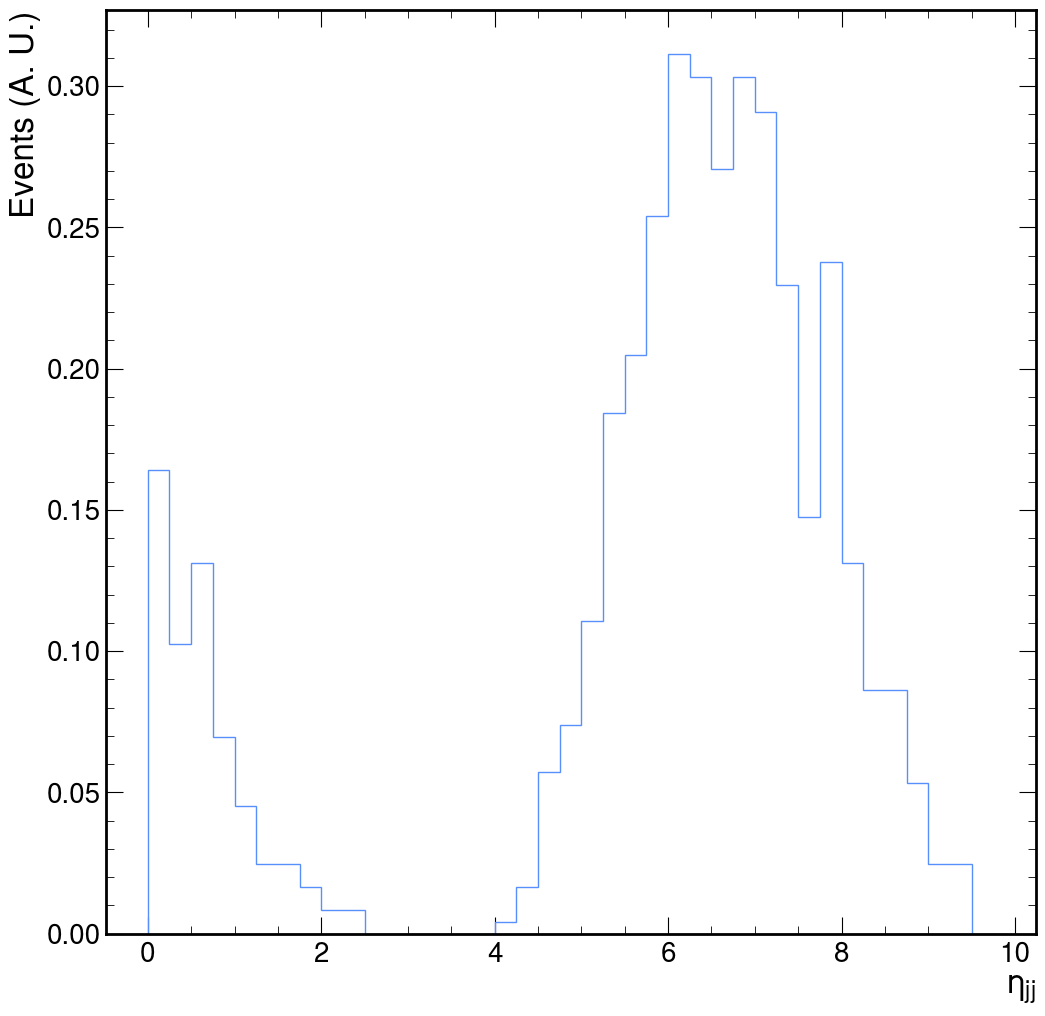

In [33]:
etas = pad_val(vbf_jets[ak.fill_none((ak.count(vbf_jets.pt, axis=1) >= 2), False)].eta, 2, axis=1)

etas = pad_val(vbf_jets.eta, 2, axis=1)

plt.rcParams.update({"font.size": 24})
plt.figure(figsize=(12, 12))
plt.hist(np.abs(etas[:, 0] - etas[:, 1]), np.arange(0, 10, 0.25), histtype="step", density=True)
plt.xlabel(r"$\eta_{jj}$")
plt.ylabel("Events (A. U.)")
plt.savefig(plot_dir / "selection_eta_jj.pdf", bbox_inches="tight")
plt.show()